In [5]:
# =========================================
# Forest Fire Burned Area Prediction
# =========================================

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

sns.set_style("whitegrid")


In [6]:
# Load dataset
data = pd.read_csv("forestfires.csv")

print("Dataset shape:", data.shape)
display(data.head())


Dataset shape: (517, 13)


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [7]:
print(data.columns)

Index(['X', 'Y', 'month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH',
       'wind', 'rain', 'area'],
      dtype='str')


In [8]:
# Encode month and day
label_encoder = LabelEncoder()

for col in ["month", "day"]:
    data[col] = label_encoder.fit_transform(data[col])

# Log-transform burned area
data["log_area"] = np.log1p(data["area"])

# Define features and target
X = data.drop(columns=["area", "log_area"])
y = data["log_area"]

print("Feature shape:", X.shape)
print("Target shape:", y.shape)

Feature shape: (517, 12)
Target shape: (517,)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

print("Training set:", X_train.shape)
print("Test set:", X_test.shape)


Training set: (413, 12)
Test set: (104, 12)


In [10]:
models = {
    "Linear": LinearRegression(),
    "RandomForest": RandomForestRegressor(
        n_estimators=200,
        random_state=42
    ),
    "GradientBoost": GradientBoostingRegressor(random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)

    results[name] = {"RMSE": rmse, "R2": r2}

    print(f"{name}: RMSE = {rmse:.3f} | R² = {r2:.3f}")


Linear: RMSE = 1.485 | R² = -0.004
RandomForest: RMSE = 1.522 | R² = -0.054
GradientBoost: RMSE = 1.532 | R² = -0.068


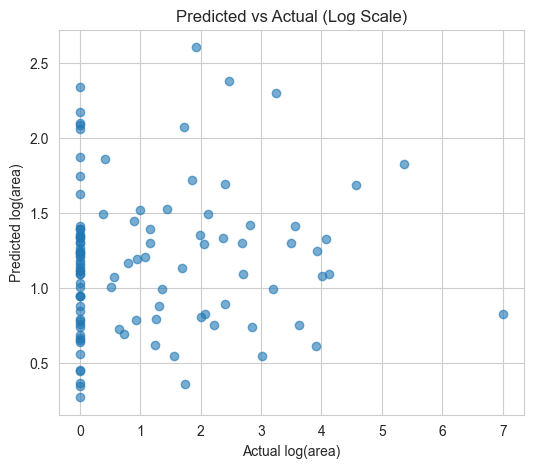

In [11]:
rf_model = models["RandomForest"]

rf_preds_log = rf_model.predict(X_test)

plt.figure(figsize=(6, 5))
plt.scatter(y_test, rf_preds_log, alpha=0.6)
plt.xlabel("Actual log(area)")
plt.ylabel("Predicted log(area)")
plt.title("Predicted vs Actual (Log Scale)")
plt.show()


In [12]:
y_test_ha = np.expm1(y_test)
rf_preds_ha = np.expm1(rf_preds_log)


In [13]:
rmse = np.sqrt(mean_squared_error(y_test_ha, rf_preds_ha))
mae = mean_absolute_error(y_test_ha, rf_preds_ha)
r2 = r2_score(y_test_ha, rf_preds_ha)

print("RandomForest Performance (Original Scale)")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"R²: {r2:.3f}")


RandomForest Performance (Original Scale)
RMSE: 109.988
MAE: 19.978
R²: -0.026


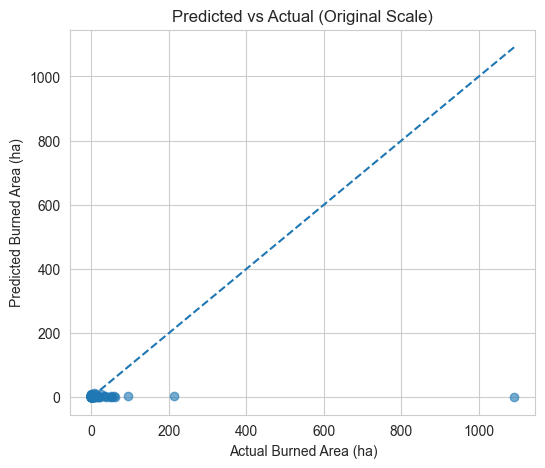

In [14]:
plt.figure(figsize=(6, 5))
plt.scatter(y_test_ha, rf_preds_ha, alpha=0.6)

max_val = max(y_test_ha.max(), rf_preds_ha.max())
plt.plot([0, max_val], [0, max_val], linestyle="--")

plt.xlabel("Actual Burned Area (ha)")
plt.ylabel("Predicted Burned Area (ha)")
plt.title("Predicted vs Actual (Original Scale)")
plt.show()


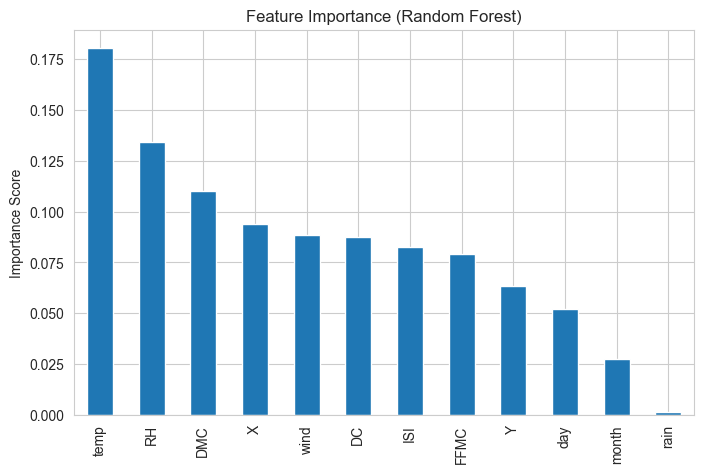

In [15]:
importance = rf_model.feature_importances_

feature_imp = pd.Series(
    importance,
    index=X.columns
).sort_values(ascending=False)

plt.figure(figsize=(8, 5))
feature_imp.plot(kind="bar")
plt.title("Feature Importance (Random Forest)")
plt.ylabel("Importance Score")
plt.show()


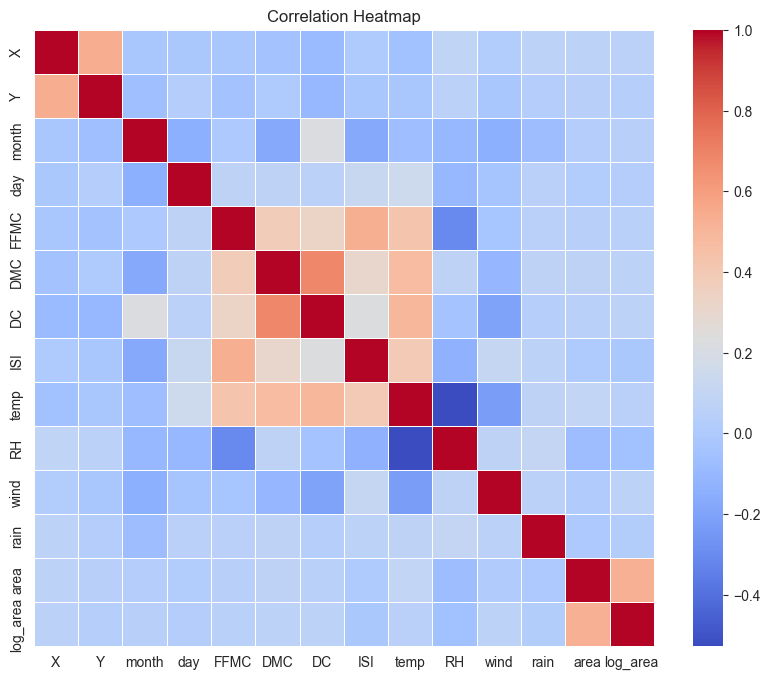

In [16]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    data.select_dtypes(include=["number"]).corr(),
    cmap="coolwarm",
    linewidths=0.5
)
plt.title("Correlation Heatmap")
plt.show()


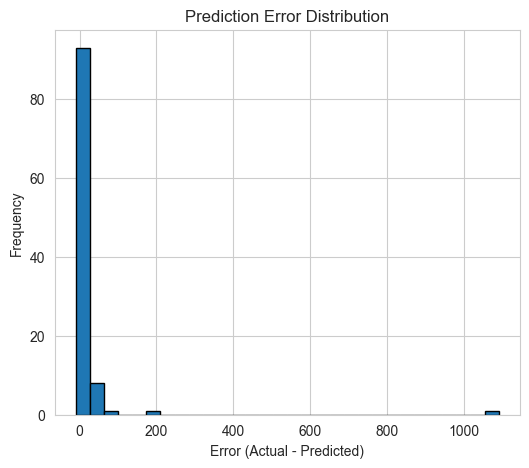

In [17]:
errors = y_test_ha - rf_preds_ha

plt.figure(figsize=(6, 5))
plt.hist(errors, bins=30, edgecolor="black")
plt.title("Prediction Error Distribution")
plt.xlabel("Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.show()


In [18]:
joblib.dump(rf_model, "burned_area_model.pkl")
print("Model saved successfully.")


Model saved successfully.
